# Öğrenme Orannı
Öğerenme oranı gradyan inişi algoritmasının uygun parametreleri elde etme hzını ve optimum değerlere ulaşabilmesi açısından önem arzeden bir değerdir. Konuyu daha iyi pekiştirebilmek için bir örenke üzerinden gitmenin daha sağlıklı olacağı görüşündeyim.


In [1]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; 
plt.style.use('./deeplearning.mplstyle')

OSError: './deeplearning.mplstyle' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

## Problem Durumu
Eğitim veri seti, aşağıdaki tabloda gösterilen 4 özellikten (boyut, yatak odası sayısı, kat sayısı ve yaş) oluşan birçok örnek içermektedir.
Bu değerleri kullanarak bir lineer regresyon modeli oluşturmak istiyoruz, böylece başka evlerin fiyatını tahmin edebiliriz. Örneğin: 1200 sqft, 3 yatak odası, 1 katlı ve 40 yıllık bir evin fiyatını tahmin edebiliriz.
###  Dataset: 
| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|----------------------- |  
| 952             | 2                   | 1                | 65           | 271.5                  |  
| 1244            | 3                   | 2                | 64           | 232                    |  
| 1947            | 3                   | 2                | 17           | 509.8                  |  
| ...             | ...                 | ...              | ...          | ...                    |


In [2]:
veriler = pd.read_csv("data/houses.csv")
X_train = veriler[['size(sqft)', 'bedrooms', 'floors', 'age']]
X_train = np.array(X_train)
X_features = ['size(sqft)', 'bedrooms', 'floors', 'age']
y_train = veriler['price(1000s dollars)']
print(X_train, y_train)


[[9.520e+02 2.000e+00 1.000e+00 6.500e+01]
 [1.244e+03 3.000e+00 1.000e+00 6.400e+01]
 [1.947e+03 3.000e+00 2.000e+00 1.700e+01]
 [1.725e+03 3.000e+00 2.000e+00 4.200e+01]
 [1.959e+03 3.000e+00 2.000e+00 1.500e+01]
 [1.314e+03 2.000e+00 1.000e+00 1.400e+01]
 [8.640e+02 2.000e+00 1.000e+00 6.600e+01]
 [1.836e+03 3.000e+00 1.000e+00 1.700e+01]
 [1.026e+03 3.000e+00 1.000e+00 4.300e+01]
 [3.194e+03 4.000e+00 2.000e+00 8.700e+01]
 [7.880e+02 2.000e+00 1.000e+00 8.000e+01]
 [1.200e+03 2.000e+00 2.000e+00 1.700e+01]
 [1.557e+03 2.000e+00 1.000e+00 1.800e+01]
 [1.430e+03 3.000e+00 1.000e+00 2.000e+01]
 [1.220e+03 2.000e+00 1.000e+00 1.500e+01]
 [1.092e+03 2.000e+00 1.000e+00 6.400e+01]
 [8.480e+02 1.000e+00 1.000e+00 1.700e+01]
 [1.682e+03 3.000e+00 2.000e+00 2.300e+01]
 [1.768e+03 3.000e+00 2.000e+00 1.800e+01]
 [1.040e+03 3.000e+00 1.000e+00 4.400e+01]
 [1.652e+03 2.000e+00 1.000e+00 2.100e+01]
 [1.088e+03 2.000e+00 1.000e+00 3.500e+01]
 [1.316e+03 3.000e+00 1.000e+00 1.400e+01]
 [1.593e+03

Verileri grfik üzerinde görselleştirelim.

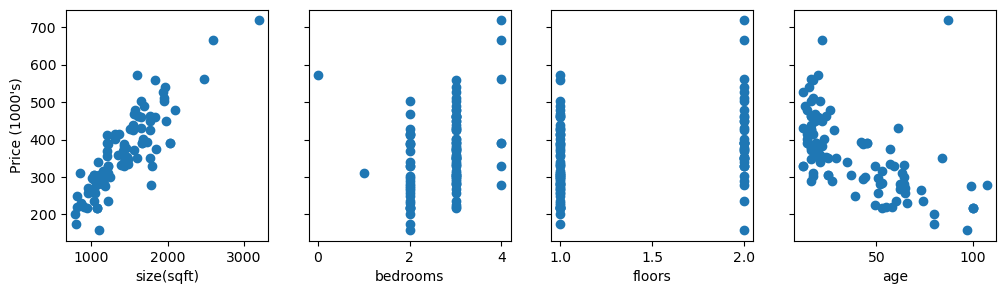

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

Her özelliği hedef değişken olan fiyat ile karşılaştırmak, hangi özelliklerin fiyat üzerinde en güçlü etkiye sahip olduğunu belirlemek için bazı ipuçları verir. Yukarıda, artan büyüklüğün fiyatı da artırdığı görülmektedir. Yatak odası sayısı ve kat sayısı, fiyat üzerinde güçlü bir etkiye sahip gibi görünmüyor. Daha yeni evlerin, daha eski evlere kıyasla daha yüksek fiyatlara sahip olduğu görülüyor.

## Çok Özellikli Gradyan İnişi Fonksiyonu
Gradyan inişi fonksiyonunu tekrar hatırlatmak gerekirse;
$$\begin{align*} \text{yakınsayana}&\text{ kadar tekrarla:} \; \lbrace \newline\;
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j}  \; & \text{for j = 0..n-1}\newline
&b\ \ := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$
Burada $n$, özelliklerin sayısını ifade eder. Paremetreler $w_j$ ve $b$, aynı anda güncellenir ve şu şekilde;
$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)}   \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) 
\end{align}
$$
- $m$ veri setindeki eğitim örenklerini ifade eder.
- $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ model tahminini, $y^{(i)}$ hedef değeri ifade eder.

## Öğrenme Oranı
Öğrenme oranı, parametreler üzerindeki güncelleme büyüklüğünü kontrol eder. Şimdi gradient descent'i çalıştıralım ve veri setimizde birkaç farklı $\alpha$ ayarı deneyelim.

### $\alpha$ = 9.9e-7

In [4]:
def compute_cost(X, y, w, b):
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b
        cost += (f_wb_i - y[i]) ** 2
    cost /= 2 * m
    return cost

In [5]:
def compute_gradient(X, y, w, b):
    m, n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        err = (np.dot(X[i], w) + b) - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err * X[i, j]
        dj_db = dj_db + err
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

In [6]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    J_history = []
    w = copy.deepcopy(w_in)
    b = b_in

    for i in range(num_iters):

        dj_db, dj_dw = gradient_function(X, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i < 100000:
            J_history.append(cost_function(X, y, w, b))

        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")

    return w, b, J_history

In [7]:
m, n = X_train.shape
initial_w = np.zeros(n)
initial_b = 0.
iterations = 1000
alpha = 9.9e-7
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient,
                                            alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
for i in range(5):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost 93105.49   
Iteration  100: Cost 89304210039813104.00   
Iteration  200: Cost 87126345163606150088736374784.00   
Iteration  300: Cost 85001591953880968430358914997992101511168.00   
Iteration  400: Cost 82928655174578680703396854794526045217372726664101888.00   
Iteration  500: Cost 80906271176610258110617958451608059874736882730217325001472737280.00   
Iteration  600: Cost 78933207127538466311856929837227867287810976902711476486388276781661745577984.00   
Iteration  700: Cost 77008260260053700507544927250810574270864062598993207399864684232976963946466329887768576.00   
Iteration  800: Cost 75130257138773156333081815526447617591881677504359912192174114446571880618038748208579647315464159232.00   
Iteration  900: Cost 73298052944928411932624523223721571526309879160038513283898273600482605255562371630008997768283744991520825016320.00   
b,w found by gradient descent: -145771450158962934969272701860161812350331842591316770816.00,[-2.23577461e+59 -4.10549283e+56 -2.1

Öğrenme oranının çok yüksek olduğu görünüyor. Çözüm yakınsamıyor. Maliyet artıyor ve azalmıyor. Sonucu görselleştirelim:

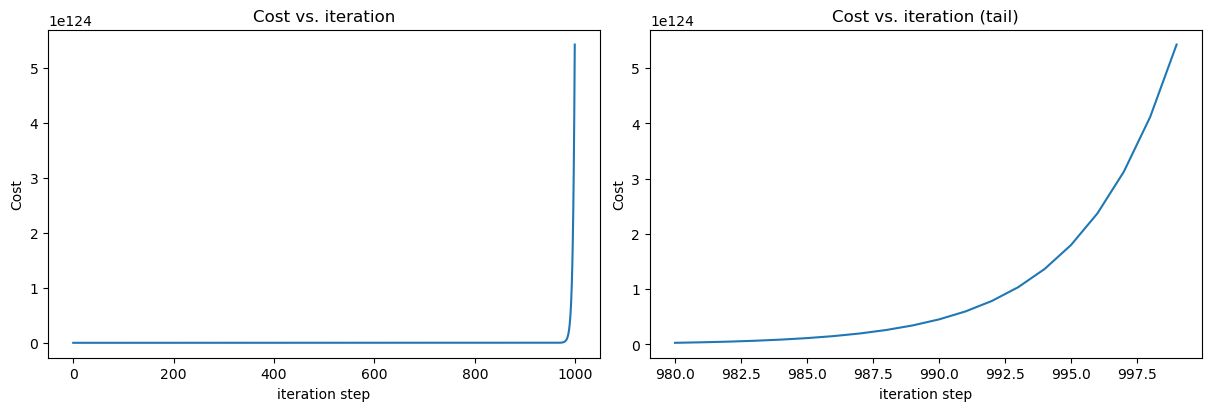

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(980 + np.arange(len(J_hist[980:])), J_hist[980:])
ax1.set_title("Cost vs. iteration");
ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost');
ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step');
ax2.set_xlabel('iteration step')
plt.show()

### $\alpha$ = 9e-7
Daha küçük bir öğrenme oranını deneyelim

In [9]:
alpha = 9e-7
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient,
                                            alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
for i in range(5):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost 64613.73   
Iteration  100: Cost  1537.64   
Iteration  200: Cost  1503.80   
Iteration  300: Cost  1478.47   
Iteration  400: Cost  1457.01   
Iteration  500: Cost  1438.84   
Iteration  600: Cost  1423.45   
Iteration  700: Cost  1410.41   
Iteration  800: Cost  1399.36   
Iteration  900: Cost  1390.01   
b,w found by gradient descent: 0.01,[ 0.26249788 -0.00355709 -0.00686245 -0.39314262] 
prediction: 224.33, target value: 271.5
prediction: 301.37, target value: 300.0
prediction: 504.38, target value: 509.8
prediction: 436.28, target value: 394.0
prediction: 508.32, target value: 540.0


Maliyet, iterasyonlar süresince azalıyor bu da $\alpha$ değerinin aşırı büyük olmadığını gösterir.

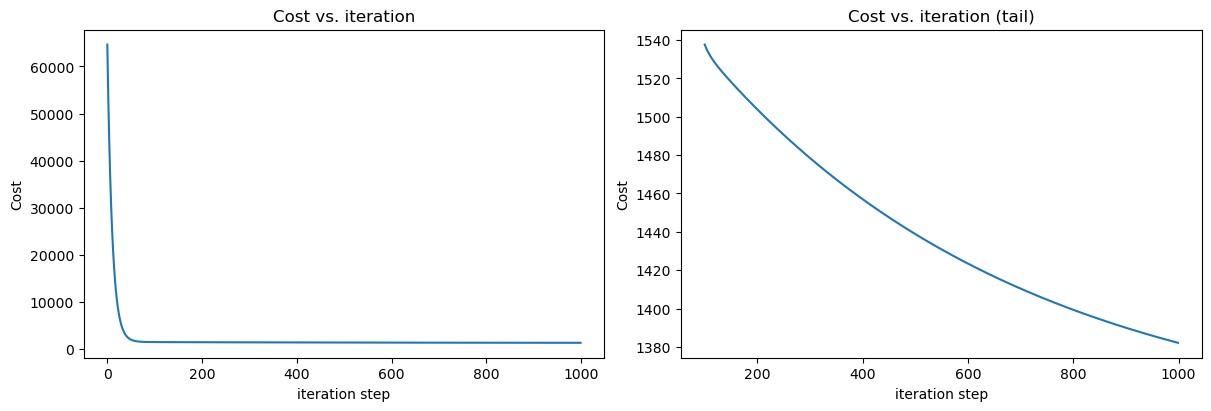

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");
ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost');
ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step');
ax2.set_xlabel('iteration step')
plt.show()

### $\alpha$ = 1e-7
Şimdi de önceki değerlere göre çok daha küçük bir $\alpha$ değeri deniyelim.

In [11]:
alpha = 1e-7
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient,
                                            alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
for i in range(5):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost 44154.43   
Iteration  100: Cost  1565.13   
Iteration  200: Cost  1560.99   
Iteration  300: Cost  1556.92   
Iteration  400: Cost  1552.92   
Iteration  500: Cost  1549.00   
Iteration  600: Cost  1545.15   
Iteration  700: Cost  1541.36   
Iteration  800: Cost  1537.65   
Iteration  900: Cost  1534.01   
b,w found by gradient descent: 0.00,[ 2.54443890e-01 -1.51872883e-04 -5.74533712e-04 -5.63067399e-02] 
prediction: 238.57, target value: 271.5
prediction: 312.92, target value: 300.0
prediction: 494.44, target value: 509.8
prediction: 436.55, target value: 394.0
prediction: 497.61, target value: 540.0


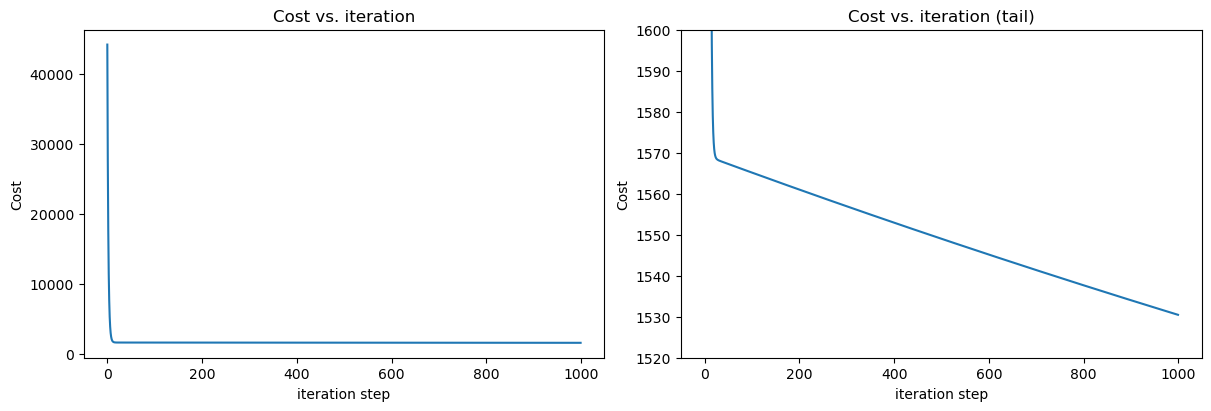

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(0 + np.arange(len(J_hist[:])), J_hist[:])
ax1.set_title("Cost vs. iteration");
ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost');
ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step');
ax2.set_xlabel('iteration step');
ax2.set_ylim(1520, 1600)
plt.show()

Gördüğünüz gibi öğrenme oranı çok küçük olduğundan iterasyona bağlı maliyet düşüşü de çok yavaş olmaktadır. Buna bağlı olarak parametrelerin optimum değerlere ulaşabilmesi için iterasyon sayısının arttırılması gerekmektedir.

## Özellik Ölçekleme
Hadi, $\alpha = 9e-7$ durumu üzerinde tekrar düşünelim. Bu değer, $\alpha$ için sapmadan ayarlayabileceğimiz maksimum değere oldukça yakındır. Aşağıda ilk birkaç iterasyonu gösteren kısa bir çalışma bulunmaktadır:
<figure>
    <img src="./ShortRun.PNG" style="width:1200px;" >
</figure>

Yukarıda, maliyetin azaldığı görülse de, $w_0$'ın, diğer parametrelere kıyasla çok daha büyük bir gradyana sahip olması nedeniyle daha hızlı ilerleme kaydettiği açıktır.

Aşağıdaki grafik, $\alpha=9e-7$ ile yapılan çok uzun bir çalışmanın sonucunu göstermektedir. Bu işlem birkaç saat sürmektedir.
<figure>
    <img src="./LongRun.PNG" style="width:1200px;" >
</figure>

Yukarıda, maliyetin ilk azalmadan sonra yavaşça azaldığını görebilirsiniz. `w0` ile `w1`, `w2`, `w3` arasındaki farkın yanı sıra `dj_dw0` ve `dj_dw1` arasındaki farklara dikkat edin. `w0`, nihai değerine çok hızlı bir şekilde ulaşmış ve `dj_dw0` hızla küçük bir değere düşerek `w0`'ın nihai değerine yakın olduğunu göstermektedir.  
Diğer parametreler ise çok daha yavaş bir şekilde azalmıştır.

Bu neden böyle? İyileştirebileceğimiz bir şey var mı? Aşağıya bakın:
<figure>
    <center> <img src="./scale.PNG"></center>
</figure>   


Yukarıdaki şekil, $w$'lerin neden düzensiz güncellendiğini göstermektedir:
- $\alpha$, tüm parametre güncellemelerinde ($w$'ler ve $b$) ortaktır.
- $w$'ler için ortak hata terimi, özelliklerle çarpılmaktadır (ancak $b$ için değil).
- Özellikler, büyüklük açısından önemli ölçüde farklılık göstermektedir; bu da bazı özelliklerin diğerlerinden çok daha hızlı güncellenmesine neden olur.
Bu durumda $w_0$, genellikle >1000 olan "size(sqft)"ile çarpılırken, $w_1$, genellikle 2-4 aralığında olan "number of bedrooms" ile çarpılmaktadır.
 
Çözüm: Özellik Ölçekleme (Feature Scaling).

Özellik ölçeklendirme, esasen her pozitif özelliğin maksimum değerine bölünmesi veya daha genel olarak, (x-min)/(max-min) kullanılarak her özelliğin hem minimum hem de maksimum değerlerine göre yeniden ölçeklendirilmesi. Her iki yol da özellikleri -1 ve 1 aralığına normalleştirir; burada ilk yöntem, basit olan ve iyi hizmet veren pozitif özellikler için çalışır ve ikinci yöntem, tüm özellikler için işe yarar.
- Ortalama normalizasyon: $x_i := \dfrac{x_i - \mu_i}{max - min} $ 
- Aşağıda inceleyeceğimiz Z-puanı normalizasyonu.


### z-puanı normalizasyonu 
Z-puanı normalizasyonundan sonra tüm özelliklerin ortalaması 0 ve standart sapması 1 olacaktır.Z-puanı normalleştirmesini uygulamak için giriş değerlerinizi bu formülde gösterildiği gibi ayarlayın:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} $$  
burada $j$, $\mathbf{X}$ matrisinde bir özelliği veya bir sütunu seçer. $μ_j$, $j$ özelliğinin tüm değerlerinin ortalamasıdır ve $\sigma_j$, $j$ özelliğinin standart sapmasıdır.
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  
\end{align}
$$


Uygulama Notu: Özellikleri normalleştirirken, normalleştirme için kullanılan değerleri - hesaplamalarda kullanılan ortalama değer ve standart sapmayı - saklamak önemlidir. Modelden parametreler öğrenildikten sonra, genellikle daha önce görmediğimiz evlerin fiyatlarını tahmin etmek isteriz. Yeni bir x değeri (oturma odası alanı ve yatak odası sayısı) verildiğinde, önce x'i, eğitim setinden daha önce hesapladığımız ortalama ve standart sapma kullanarak normalleştirmemiz gerekir.

In [15]:
def zscore_normalize_features(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return (X_norm, mu, sigma)

Haydi, Z-puanı normalizasyonunda yer alan adımlara bir göz atalım. Aşağıdaki grafik, dönüşüm sürecini adım adım göstermektedir.

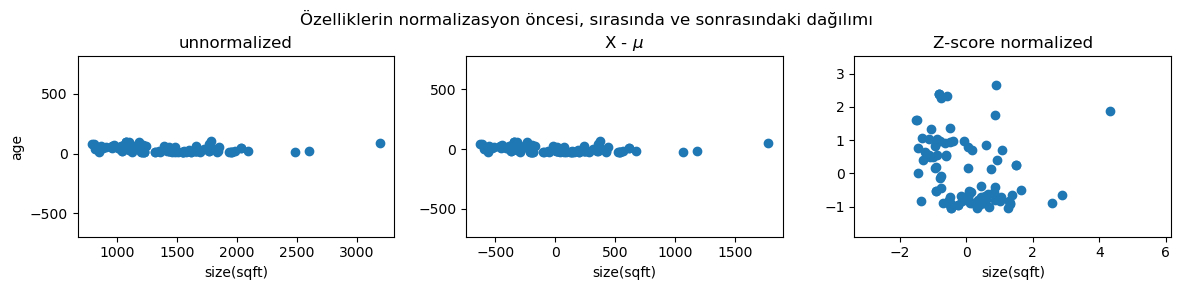

In [16]:
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)
X_mean = (X_train - mu)
X_norm = (X_train - mu) / sigma

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(X_train[:, 0], X_train[:, 3])
ax[0].set_xlabel(X_features[0]);
ax[0].set_ylabel(X_features[3]);
ax[0].set_title("unnormalized")
ax[0].axis('equal')

ax[1].scatter(X_mean[:, 0], X_mean[:, 3])
ax[1].set_xlabel(X_features[0]);
ax[0].set_ylabel(X_features[3]);
ax[1].set_title(r"X - $\mu$")
ax[1].axis('equal')

ax[2].scatter(X_norm[:, 0], X_norm[:, 3])
ax[2].set_xlabel(X_features[0]);
ax[0].set_ylabel(X_features[3]);
ax[2].set_title(r"Z-score normalized")
ax[2].axis('equal')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Özelliklerin normalizasyon öncesi, sırasında ve sonrasındaki dağılımı")
plt.show()

Yukarıdaki grafik, eğitim seti parametrelerinden ikisi olan "yaş" ve "boyut (metrekare)" arasındaki ilişkiyi göstermektedir. Bu grafikler eşit ölçekle çizilmiştir.

- Sol: Normalleştirilmemiş: "Boyut (metrekare)" özelliğinin değer aralığı veya varyansı, "yaş" özelliğinkinden çok daha büyüktür.
- Orta: İlk adım, her bir özelliğin ortalama veya ortalama değerini çıkarır. Bu, sıfır etrafında merkezlenmiş özellikler bırakır. "Yaş" özelliği için farkı görmek zor olsa da, "boyut (metrekare)" açıkça sıfır etrafındadır.
- Sağ: İkinci adım, standart sapmaya bölmektir. Bu, her iki özelliğin de sıfır etrafında merkezlenmesini ve benzer bir ölçeğe sahip olmasını sağlar.

Haydi verileri normalleştirelim ve orijinal verilerle karşılaştıralım.

In [17]:
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Ham verilerde sütun bazında zirveden zirveye aralık (Peak to Peak range) X:{np.ptp(X_train, axis=0)}")
print(
    f"Normalleştirilmiş verilerde sütun bazında zirveden zirveye aralık (Peak to Peak range) X:{np.ptp(X_norm, axis=0)}")

X_mu = [1.41371e+03 2.71000e+00 1.38000e+00 3.86500e+01], 
X_sigma = [412.17283499   0.65261014   0.48538644  25.78502472]
Ham verilerde sütun bazında zirveden zirveye aralık (Peak to Peak range) X:[2.406e+03 4.000e+00 1.000e+00 9.500e+01]
Normalleştirilmiş verilerde sütun bazında zirveden zirveye aralık (Peak to Peak range) X:[5.83735704 6.12923357 2.06021411 3.68430905]


Her sütunun zirveden zirveye aralığı, normalizasyon ile binlerce katından 2-3 katına düşürülmüştür.

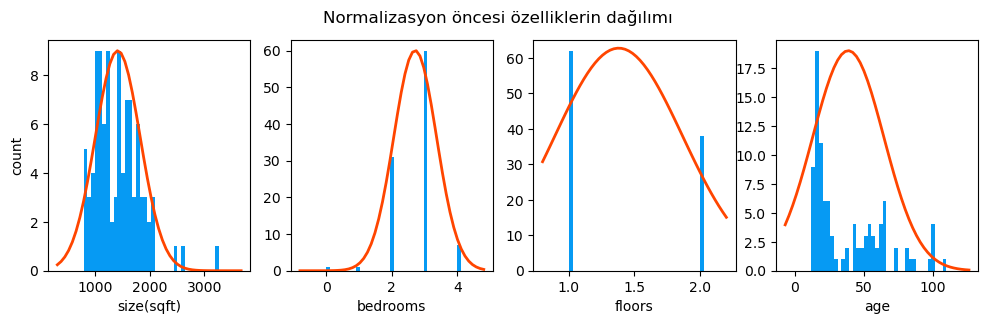

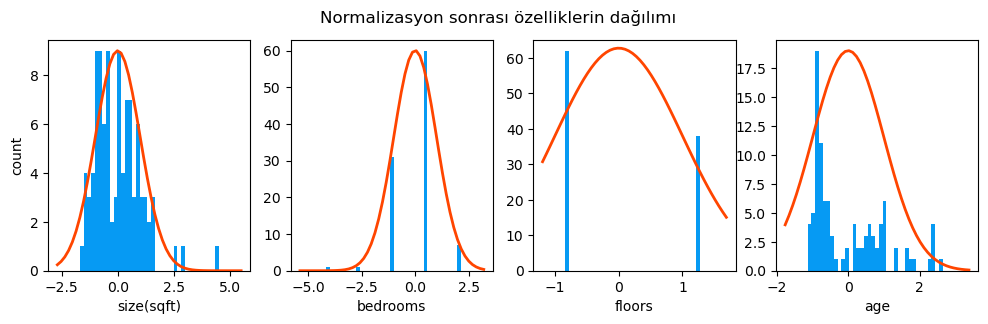

In [18]:
def norm_plot(ax, data):
    scale = (np.max(data) - np.min(data)) * 0.2
    x = np.linspace(np.min(data) - scale, np.max(data) + scale, 50)
    _, bins, _ = ax.hist(data, x, color="xkcd:azure")
    #ax.set_ylabel("Count")

    mu = np.mean(data);
    std = np.std(data);
    dist = norm.pdf(bins, loc=mu, scale=std)

    axr = ax.twinx()
    axr.plot(bins, dist, color="orangered", lw=2)
    axr.set_ylim(bottom=0)
    axr.axis('off')


fig, ax = plt.subplots(1, 4, figsize=(12, 3))

for i in range(len(ax)):
    norm_plot(ax[i], X_train[:, i], )
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count");
fig.suptitle("Normalizasyon öncesi özelliklerin dağılımı")
plt.show()
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    norm_plot(ax[i], X_norm[:, i], )
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count");
fig.suptitle("Normalizasyon sonrası özelliklerin dağılımı")

plt.show()

Yukarıda dikkat edin, normalleştirilmiş verilerin aralığı (x ekseni) sıfır etrafında merkezlenmiş ve yaklaşık olarak +/- 2'ye yakın. En önemlisi, her bir özellik için aralık benzer şekilde dağılmıştır.

Haydi, normalleştirilmiş verilerle gradient descent algoritmamızı tekrar çalıştıralım. **Alpha değerinin çok daha büyük olduğunu** unutmayın. Bu, gradient descent'i hızlandıracaktır.

In [19]:
def gradient_descent_houses(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X : (array_like Shape (m,n)    matrix of examples 
      y : (array_like Shape (m,))    target value of each example
      w_in : (array_like Shape (n,)) Initial values of parameters of the model
      b_in : (scalar)                Initial value of parameter of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """

    # number of training examples
    m = len(X)

    # An array to store values at each iteration primarily for graphing later
    hist = {}
    hist["cost"] = [];
    hist["params"] = [];
    hist["grads"] = [];
    hist["iter"] = [];

    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    save_interval = np.ceil(num_iters / 10000)  # prevent resource exhaustion for long runs

    print(
        f"Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  ")
    print(
        f"---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|")

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w, b)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J,w,b at each save interval for graphing
        if i == 0 or i % save_interval == 0:
            hist["cost"].append(cost_function(X, y, w, b))
            hist["params"].append([w, b])
            hist["grads"].append([dj_dw, dj_db])
            hist["iter"].append(i)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters / 10) == 0:
            #print(f"Iteration {i:4d}: Cost {cost_function(X, y, w, b):8.2f}   ")
            cst = cost_function(X, y, w, b)
            print(
                f"{i:9d} {cst:0.5e} {w[0]: 0.1e} {w[1]: 0.1e} {w[2]: 0.1e} {w[3]: 0.1e} {b: 0.1e} {dj_dw[0]: 0.1e} {dj_dw[1]: 0.1e} {dj_dw[2]: 0.1e} {dj_dw[3]: 0.1e} {dj_db: 0.1e}")

    return w, b, hist  #return w,b and history for graphing

def compute_gradient_matrix(X, y, w, b): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X : (array_like Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) Values of parameters of the model      
      b : (scalar )                Values of parameter of the model      
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
                                  
    """
    m,n = X.shape
    f_wb = X @ w + b              
    e   = f_wb - y                
    dj_dw  = (1/m) * (X.T @ e)    
    dj_db  = (1/m) * np.sum(e)    
        
    return dj_db,dj_dw

def run_gradient_descent(X, y, iterations=1000, alpha=1e-6):
    m, n = X.shape
    # initialize parameters
    initial_w = np.zeros(n)
    initial_b = 0
    # run gradient descent
    w_out, b_out, hist_out = gradient_descent_houses(X, y, initial_w, initial_b,compute_cost, compute_gradient_matrix, alpha, iterations)
    print(f"w,b found by gradient descent: w: {w_out}, b: {b_out:0.2f}")

    return (w_out, b_out, hist_out)

In [20]:
w_norm, b_norm, hist = run_gradient_descent(X_norm, y_train, 1000, 1.0e-1, )

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 5.73264e+04  8.9e+00  3.0e+00  3.3e+00 -6.0e+00  3.6e+01 -8.9e+01 -3.0e+01 -3.3e+01  6.0e+01 -3.6e+02
      100 2.21728e+02  1.1e+02 -2.0e+01 -3.1e+01 -3.8e+01  3.6e+02 -9.4e-01  4.6e-01  5.4e-01 -1.8e-01 -9.6e-03
      200 2.19714e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.3e-02  1.6e-02  1.8e-02 -6.4e-03 -2.6e-07
      300 2.19711e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -1.1e-03  5.7e-04  6.3e-04 -2.2e-04 -6.9e-12
      400 2.19711e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.9e-05  2.0e-05  2.2e-05 -7.6e-06 -2.2e-13
      500 2.19711e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -1.3e-06  6.8e-07  7.5e-07 -2.6e-07 -2.2e-13
      600 2.19711e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -4.7e-08  2.4e-08  2.6e-08 -9.1e-09 -

Ölçeklendirilmiş özellikler, çok, çok daha hızlı doğru sonuçlar elde eder! Bu kısa çalıştırmanın sonunda her bir parametrenin gradyanı oldukça küçük. Normalleştirilmiş özelliklerle regresyon için 0.1'lik bir öğrenme oranı iyi bir başlangıçtır.

Şimdi tahminlerimizi hedef değerlerle karşılaştırarak çizelim. Dikkat edin, tahmin normalleştirilmiş özellik kullanılarak yapılırken, grafik orijinal özellik değerleriyle gösterilmektedir.

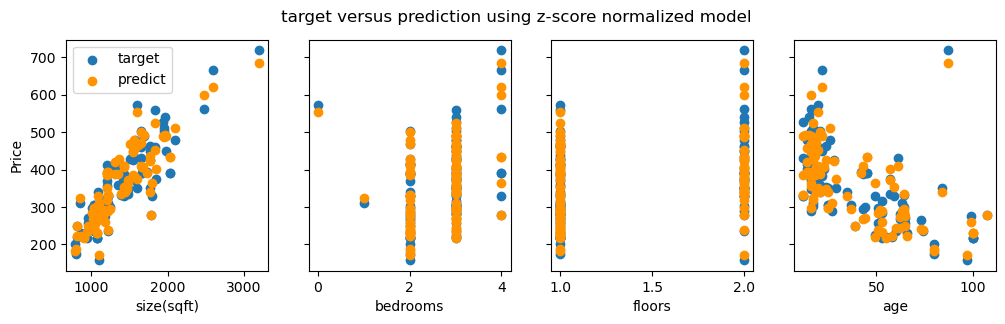

In [21]:
#predict target using normalized features
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],yp,color="#FF9300", label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

Sonuçlar iyi görünüyor. Dikkat edilmesi gereken birkaç nokta:

- Birden fazla özellik olduğunda, artık sonuçları özelliklere karşı gösteren tek bir grafik kullanamayız.
- Grafik oluşturulurken normalleştirilmiş özellikler kullanıldı. Normalleştirilmiş bir eğitim seti ile öğrenilen parametrelerle yapılan herhangi bir tahmin de normalleştirilmiş olmalıdır.
Bu, normalizasyonun modelin eğitilmesi ve tahminler için tutarlı bir şekilde uygulanması gerektiğini vurgulamaktadır. Özellikler normalleştirildiyse, tahminler de aynı şekilde normalleştirilmelidir, aksi takdirde sonuçlar hatalı olabilir.

**Tahmin**

Modelimizi oluşturma amacımız, veri setinde bulunmayan ev fiyatlarını tahmin etmektir. Şimdi, 1200 sqft, 3 yatak odası, 1 kat ve 40 yaşında olan bir evin fiyatını tahmin edelim. Unutmayın, verileri normalleştirirken kullanılan ortalama ve standart sapmayı kullanarak verileri normalleştirmeniz gerektiğini hatırlayın.

In [22]:
# First, normalize out example.
x_house = np.array([1200, 3, 1, 40])
x_house_norm = (x_house - X_mu) / X_sigma
print(x_house_norm)
x_house_predict = np.dot(x_house_norm, w_norm) + b_norm
print(f" 1200 sqft, 3 yatak odalı, 1 katlı, 40 yaşında bir evin tahmin edilen fiyatı = ${x_house_predict*1000:0.0f}")

[-0.51849608  0.44436943 -0.78288136  0.05235597]
 1200 sqft, 3 yatak odalı, 1 katlı, 40 yaşında bir evin tahmin edilen fiyatı = $318936


**Maliyet Konturları**

<img align="left" src="./contours.PNG" style="width:240px;" >Özellik ölçeklemesini bir başka şekilde görmek, maliyet konturları açısından mümkündür. Özelliklerin ölçekleri eşleşmediğinde, maliyetin parametreler ile karşılaştırıldığı kontur grafiği asimetrik olur.

Aşağıdaki grafikte, parametrelerin ölçekleri eşleştirilmiştir. Sol taraftaki grafik, özellikler normalize edilmeden önce kareler metrekare w[0] ile yatak odası sayısı w[1] arasındaki maliyet kontur grafiğidir. Grafik o kadar asimetriktir ki, konturları tamamlayan eğriler görünmez. Buna karşılık, özellikler normalize edildiğinde, maliyet konturu çok daha simetrik hale gelir. Sonuç olarak, gradyan inişi sırasında parametrelerdeki güncellemeler her parametre için eşit bir ilerleme kaydedebilir.

In [23]:
def plt_contour_multi(x, y, w, b, ax, prange, p1, p2, title="", xlabel="", ylabel=""): 
    contours = [1e2, 2e2,3e2,4e2, 5e2, 6e2, 7e2,8e2,1e3, 1.25e3,1.5e3, 1e4, 1e5, 1e6, 1e7]
    px,py = np.meshgrid(np.linspace(*(prange[p1])),np.linspace(*(prange[p2])))
    z=np.zeros_like(px)
    n,_ = px.shape
    for i in range(px.shape[0]):
        for j in range(px.shape[1]):
            w_ij = w
            b_ij = b
            if p1 <= 3: w_ij[p1] = px[i,j]
            if p1 == 4: b_ij = px[i,j]
            if p2 <= 3: w_ij[p2] = py[i,j]
            if p2 == 4: b_ij = py[i,j]
                
            z[i][j] = compute_cost(x, y, w_ij, b_ij )
    CS = ax.contour(px, py, z, contours, linewidths=2,
                   colors=[dlblue, dlorange, dldarkred, dlmagenta, dlpurple]) 
    ax.clabel(CS, inline=1, fmt='%1.2e', fontsize=10)
    ax.set_xlabel(xlabel);  ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=14)



def plt_equal_scale(X_train, X_norm, y_train):
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    prange = [
              [ 0.238-0.045, 0.238+0.045,  50],
              [-25.77326319-0.045, -25.77326319+0.045, 50],
              [-50000, 0,      50],
              [-1500,  0,      50],
              [0, 200000, 50]]
    w_best = np.array([0.23844318, -25.77326319, -58.11084634,  -1.57727192])
    b_best = 235
    plt_contour_multi(X_train, y_train, w_best, b_best, ax[0], prange, 0, 1, 
                      title='Unnormalized, J(w,b), vs w[0],w[1]',
                      xlabel= "w[0] (size(sqft))", ylabel="w[1] (# bedrooms)")
    #
    w_best = np.array([111.1972, -16.75480051, -28.51530411, -37.17305735])
    b_best = 376.949151515151
    prange = [[ 111-50, 111+50,   75],
              [-16.75-50,-16.75+50, 75],
              [-28.5-8, -28.5+8,  50],
              [-37.1-16,-37.1+16, 50],
              [376-150, 376+150, 50]]
    plt_contour_multi(X_norm, y_train, w_best, b_best, ax[1], prange, 0, 1, 
                      title='Normalized, J(w,b), vs w[0],w[1]',
                      xlabel= "w[0] (normalized size(sqft))", ylabel="w[1] (normalized # bedrooms)")
    fig.suptitle("Cost contour with equal scale", fontsize=18)
    #plt.tight_layout(rect=(0,0,1.05,1.05))
    fig.tight_layout(rect=(0,0,1,0.95))
    plt.show()

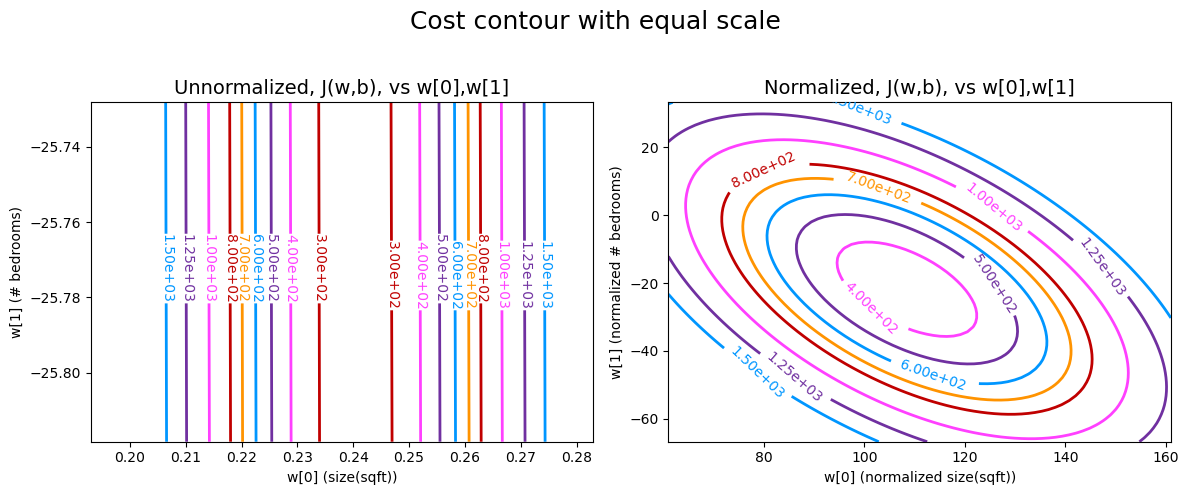

In [24]:
plt_equal_scale(X_train, X_norm, y_train)